In [ ]:
# Requirements
# pip install audiomentations[extras]

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, train_test_split

import cv2
import IPython.display as ipd
import librosa
import soundfile
import audiomentations
import albumentations
from albumentations.pytorch import ToTensor

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
# from torchvision import datasets, models, transforms, utils
from torch.utils.data import Dataset, DataLoader

import os
# from os import listdir
import time
import copy

In [124]:
# nasanyarrayaslibrosa.load("qwe.wav")

array([array([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
       -3.0517578e-05,  3.0517578e-04,  1.8310547e-04], dtype=float32),
       22050], dtype=object)

In [2]:
df_train = pd.read_csv("data/Train.csv")
sample_submission = pd.read_csv("data/SampleSubmission.csv")
df_test = sample_submission[["fn"]].copy()

In [5]:
df_train["sr"] = 0
srs = []

In [6]:
for fn in df_train.fn.values:
    _, sr = librosa.load(fn, sr = None, mono = True)
    srs.append(sr)

df_train["sr"] = srs

In [8]:
df_train.

count     1109.0
mean     22050.0
std          0.0
min      22050.0
25%      22050.0
50%      22050.0
75%      22050.0
max      22050.0
Name: sr, dtype: float64

In [63]:
df_new = pd.read_csv("data/Train.csv")

In [12]:
df_new

,fn,label
0,audio_files/IV38R7F.wav,akawuka
1,audio_files/KM4SKWT.wav,banana
2,audio_files/F5POSU9.wav,obulwadde
3,audio_files/MMVDXG2.wav,nnyaanya
4,audio_files/9TVM96F.wav,pampu
...,...,...
1104,audio_files/QNZECA9.wav,cassava
1105,audio_files/GUIY718.wav,harvesting
1106,audio_files/W38UIGC.wav,farm
1107,audio_files/E04FSN7.wav,nakavundira


In [97]:
base_path = "AdditionalUtterances/latest_keywords/"
additional_labels = os.listdir(base_path)

In [98]:
new_fns = []
new_labels = []

for label in additional_labels:
    samples_in_label = os.listdir(os.path.join(base_path, label))
    
    for sample in samples_in_label:
        file_path = os.path.join(base_path, label + "/" + sample)
        new_fns.append(file_path)
        new_labels.append(label)

In [99]:
new_labels

['abalimi',
 'abalimi',
 'abalimi',
 'abalimi',
 'abalimi',
 'abalimi',
 'abalimi',
 'abalimi',
 'abalimi',
 'abalimi',
 'abalimi',
 'afukirira',
 'afukirira',
 'afukirira',
 'afukirira',
 'afukirira',
 'afukirira',
 'afukirira',
 'afukirira',
 'akammwanyi',
 'akammwanyi',
 'akammwanyi',
 'akammwanyi',
 'akammwanyi',
 'akammwanyi',
 'akammwanyi',
 'akammwanyi',
 'akammwanyi',
 'akammwanyi',
 'akammwanyi',
 'akammwanyi',
 'akammwanyi',
 'akamonde',
 'akamonde',
 'akamonde',
 'akamonde',
 'akamonde',
 'akamonde',
 'akamonde',
 'akamonde',
 'akamonde',
 'akamonde',
 'akamonde',
 'akasaanyi',
 'akasaanyi',
 'akasaanyi',
 'akasaanyi',
 'akasaanyi',
 'akasaanyi',
 'akasaanyi',
 'akasaanyi',
 'akasaanyi',
 'akasaanyi',
 'akasaanyi',
 'akasaanyi',
 'akasaanyi',
 'akasaanyi',
 'akasaanyi',
 'akasaanyi',
 'akasaanyi',
 'akatunda',
 'akatunda',
 'akatunda',
 'akatunda',
 'akatunda',
 'akatunda',
 'akatunda',
 'akatunda',
 'akatunda',
 'akatunda',
 'akatunda',
 'akatunda',
 'akatunda',
 'akatunda'

In [100]:
df_new_ = np.asarray([new_fns, new_labels]).T
# df_new_ = np.reshape(df_new_, (-1, 2))
df_new_ = pd.DataFrame(df_new_, columns = ["fn", "label"])

In [102]:
df_new = pd.concat([df_new, df_new_], axis = 0)

In [106]:
df_new = df_new.sort_values("label").reset_index(drop = True)

In [116]:
df_new = df_new.sample(frac=1, random_state = 42).reset_index(drop = True)

In [84]:
df_new_

,0,1
0,data/AdditionalUtterances/latest_keywords/abal...,abalimi
1,data/AdditionalUtterances/latest_keywords/abal...,abalimi
2,data/AdditionalUtterances/latest_keywords/abal...,abalimi
3,data/AdditionalUtterances/latest_keywords/abal...,abalimi
4,data/AdditionalUtterances/latest_keywords/abal...,abalimi
...,...,...
1735,data/AdditionalUtterances/latest_keywords/siku...,sikungula
1736,data/AdditionalUtterances/latest_keywords/siku...,sikungula
1737,data/AdditionalUtterances/latest_keywords/siku...,sikungula
1738,data/AdditionalUtterances/latest_keywords/siku...,sikungula


In [62]:
np

array([['data/latest_keywords/abalimi/1b5a69c4b88b41eb9577a656e11bb7dd_12df330aafd44d738ddd737e6a4eec36.wav',
        'data/latest_keywords/abalimi/1b5a69c4b88b41eb9577a656e11bb7dd_620813f19de248cca304e214d5892ec6.wav'],
       ['data/latest_keywords/abalimi/1b5a69c4b88b41eb9577a656e11bb7dd_c287e8aa894841f4b8a1e1b39f7c77b2.wav',
        'data/latest_keywords/abalimi/1b5a69c4b88b41eb9577a656e11bb7dd_cbcd9fef6f2344bcadad9ac06df3fba2.wav'],
       ['data/latest_keywords/abalimi/1b5a69c4b88b41eb9577a656e11bb7dd_dbaeff9f7d5a4f8182816d8381ca01fb.wav',
        'data/latest_keywords/abalimi/5aa4893526794a73a3ed0a7ebba2a7bf_4b41e8fd3c364e5082d1b2b5bb64c8d9.wav'],
       ...,
       ['sikungula', 'sikungula'],
       ['sikungula', 'sikungula'],
       ['sikungula', 'sikungula']], dtype='<U104')

In [58]:
np.asarray([new_fns, new_labels]).res shape

(2, 1740)

In [56]:
df_new.append([[new_fns[3], new_labels[0]]])

,fn,label,0,1
0,audio_files/IV38R7F.wav,akawuka,NaN,NaN
1,audio_files/KM4SKWT.wav,banana,NaN,NaN
2,audio_files/F5POSU9.wav,obulwadde,NaN,NaN
3,audio_files/MMVDXG2.wav,nnyaanya,NaN,NaN
4,audio_files/9TVM96F.wav,pampu,NaN,NaN
...,...,...,...,...
1105,audio_files/GUIY718.wav,harvesting,NaN,NaN
1106,audio_files/W38UIGC.wav,farm,NaN,NaN
1107,audio_files/E04FSN7.wav,nakavundira,NaN,NaN
1108,audio_files/2MV9KPP.wav,nursery bed,NaN,NaN


In [46]:
pd.DataFrame([new_fns, new_labels], columns = ["fn", "label"])

ValueError: 2 columns passed, passed data had 1740 columns

In [25]:
os.listdir(os.path.join(base_path, additional_labels[0]))

['1b5a69c4b88b41eb9577a656e11bb7dd_12df330aafd44d738ddd737e6a4eec36.wav',
 '1b5a69c4b88b41eb9577a656e11bb7dd_620813f19de248cca304e214d5892ec6.wav',
 '1b5a69c4b88b41eb9577a656e11bb7dd_c287e8aa894841f4b8a1e1b39f7c77b2.wav',
 '1b5a69c4b88b41eb9577a656e11bb7dd_cbcd9fef6f2344bcadad9ac06df3fba2.wav',
 '1b5a69c4b88b41eb9577a656e11bb7dd_dbaeff9f7d5a4f8182816d8381ca01fb.wav',
 '5aa4893526794a73a3ed0a7ebba2a7bf_4b41e8fd3c364e5082d1b2b5bb64c8d9.wav',
 '5aa4893526794a73a3ed0a7ebba2a7bf_f4e07a0cbdc54593b1bf391d1ddbcfce.wav',
 'eb702740d41f4f389192ec5c6a3ae95f_19c5d3f0e5c54a9ba1c2b4f48791d332.wav',
 'eb702740d41f4f389192ec5c6a3ae95f_81e0268b31d14ac3be37700ab379b6ec.wav',
 'eb702740d41f4f389192ec5c6a3ae95f_d81514ae681445eabba416178c5d38c4.wav',
 'eb702740d41f4f389192ec5c6a3ae95f_dc4956f00b0f4aa6989052a17acdc1e3.wav']

In [35]:
os.path.join(base_path, additional_labels[0] + "/" + ,)

'data/latest_keywords/abalimi/S'

In [22]:
additional_labels[0]

'abalimi'

In [30]:
os.walk(base_path)

<generator object walk at 0x000001C6E1C40A48>

['abalimi',
 'afukirira',
 'akammwanyi',
 'akamonde',
 'akasaanyi',
 'akatunda',
 'akatungulu',
 'akawuka',
 'amakoola',
 'amakungula',
 'amalagala',
 'amappapaali',
 'amatooke',
 'bibala',
 'bulimi',
 'ddagala',
 'doodo',
 'ebbugga',
 'ebibala',
 'ebigimusa',
 'ebijanjaalo',
 'ebijjanjalo',
 'ebikajjo',
 'ebikolo',
 'ebikongoliro',
 'ebikoola',
 'ebimera',
 'ebinyebwa',
 'ebirime',
 'ebisaanyi',
 'ebisooli',
 'ebisoolisooli',
 'ebitooke',
 'ebiwojjolo',
 'ebiwuka',
 'ebyobulimi',
 'eddagala',
 'eggobe',
 'ejjobyo',
 'ekibala',
 'ekigimusa',
 'ekijanjaalo',
 'ekikajjo',
 'ekikolo',
 'ekikoola',
 'ekimera',
 'ekirime',
 'ekirwadde',
 'ekisaanyi',
 'ekitooke',
 'ekiwojjolo',
 'ekyeya',
 'emboga',
 'emicungwa',
 'emisiri',
 'emiyembe',
 'emmwanyi',
 'endagala',
 'endokwa',
 'endwadde',
 'enkota',
 'ennima',
 'ennimiro',
 'ennyaanya',
 'ensigo',
 'ensiringanyi',
 'ensujju',
 'ensuku',
 'ensukusa',
 'enva endiirwa',
 'eppapaali',
 'faamu',
 'kaamulali',
 'kasaanyi',
 'kassooli',
 'kikajjo',

In [ ]:
wav, sr = librosa.load(sample, sr = None, mono = True)

In [8]:
# update pytorch, torchvision, PIL/pillow

In [9]:
import PIL
PIL.__version__

'6.2.2'

In [10]:
import torch
torch.__version__

'1.0.0'

In [ ]:
# from PIL import Image, ExifTags
# from tqdm import tqdm

In [11]:
df_train = pd.read_csv("data/Train.csv")
sample_submission = pd.read_csv("data/SampleSubmission.csv")
df_test = sample_submission[["fn"]].copy()

### Sample an audio

In [12]:
sample = 'audio_files/E0SKITI.wav'
wav, sr = librosa.load(sample, sr = None, mono = True)
ipd.Audio(sample)

## Encode targets

In [13]:
# Quick Label encoding
df_train["target"] = df_train.label.astype("category").cat.codes

## Util functions

In [324]:
#https://github.com/TheoViel/kaggle_birdcall_identification/blob/master/src/data/transforms.py
def mono_to_color(X, eps=1e-6, mean=None, std=None):
    """
    Converts a one channel array to a 3 channel one in [0, 255]
    Arguments:
        X {numpy array [H x W]} -- 2D array to convert
    Keyword Arguments:
        eps {float} -- To avoid dividing by 0 (default: {1e-6})
        mean {None or np array} -- Mean for normalization (default: {None})
        std {None or np array} -- Std for normalization (default: {None})
    Returns:
        numpy array [3 x H x W] -- RGB numpy array
    """
    X = np.stack([X, X, X], axis=-1)

    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)

    # Normalize to [0, 255]
    _min, _max = X.min(), X.max()

    if (_max - _min) > eps:
        V = np.clip(X, _min, _max)
        V = 255 * (V - _min) / (_max - _min)
        V = V.astype(np.uint8)
    else:
        V = np.zeros_like(X, dtype=np.uint8)

    return V

In [272]:
# def mono_to_color(X, mean=None, std=None, norm_max=None, norm_min=None, eps=1e-6):
#     # Stack X as [X,X,X]
#     X = np.stack([X, X, X], axis=-1)

#     # Standardize
#     mean = mean or X.mean()
#     X = X - mean
#     std = std or X.std()
#     Xstd = X / (std + eps)
#     _min, _max = Xstd.min(), Xstd.max()
#     norm_max = norm_max or _max
#     norm_min = norm_min or _min
#     if (_max - _min) > eps:
#         # Normalize to [0, 255]
#         V = Xstd
#         V[V < norm_min] = norm_min
#         V[V > norm_max] = norm_max
#         V = 255 * (V - norm_min) / (norm_max - norm_min)
#         V = V.astype(np.uint8)
#     else:
#         # Just zero
#         V = np.zeros_like(Xstd, dtype=np.uint8)
#     return V

In [300]:
def get_audio_transforms():
    transforms = audiomentations.Compose(
        [
            audiomentations.FrequencyMask(),
            audiomentations.AddGaussianSNR(max_SNR = 0.25),
            audiomentations.AddGaussianNoise(),
            audiomentations.TimeStretch(leave_length_unchanged = False),
            audiomentations.PitchShift(),
            audiomentations.Shift(),
            audiomentations.Normalize(),
            audiomentations.Trim(),
            audiomentations.ClippingDistortion(),
#               audiomentations.AddBackgroundNoise(sounds_path=BACKGROUND_PATH, min_snr_in_db=0, max_snr_in_db=2, p=0.5)
            audiomentations.Gain(),
        ]
    )
        
    return transforms

In [319]:
def get_image_transforms(train = True):
    
    needed_transforms =         [
            albumentations.Resize(224, 224),
            albumentations.Normalize(),
            ToTensor(),
    
    transforms = albumentations.Compose(
        [
            albumentations.Resize(224, 224),
            albumentations.Normalize(),
            ToTensor(),
            if train:
                albumentations.HorizontalFlip(),
#             albumentations.RandomBrightness(),
        #     albumentations.ShiftScaleRotate(rotate_limit=15, scale_limit=0.10),
        #     albumentations.JpegCompression(80),
#             albumentations.HueSaturationValue(), 
            else:
                pass
        ]
    )
        
    return transforms

In [320]:
# def spec_to_image(spec, eps=1e-6):
#   mean = spec.mean()
#   std = spec.std()
#   spec_norm = (spec - mean) / (std + eps)
#   spec_min, spec_max = spec_norm.min(), spec_norm.max()
#   spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
#   spec_scaled = spec_scaled.astype(np.uint8)
#   return spec_scaled

In [322]:
mel_spect = librosa.feature.melspectrogram(wav, sr = sr, n_mels = 128, fmin = 20, fmax = sr / 2.0,)
mel_spect = librosa.power_to_db(mel_spect)        

In [323]:
# 1 channel
mel_spect.shape

(128, 99)

In [325]:
# 3 channels 
mono_to_color(mel_spect).shape

(128, 99, 3)

In [401]:
    def get_mel_spect(y, sr):
        mel_spect = librosa.feature.melspectrogram(
            y, sr = sr, n_mels = 128, fmin = 20, fmax = sr / 2.0,
        )

        mel_spect = librosa.power_to_db(mel_spect)
        
        return mel_spect

## Data Class

In [301]:
class MelspectrogramData(Dataset):
    def __init__(self, df, audio_transforms, image_transforms, train = True, visualization = False, sr = 44100):
        """
        Constructor
        Arguments:
            df {pandas dataframe} -- Metadata
            params {AudioParams} -- Audio parameters
        Keyword Arguments:
            train {bool} -- Whether the dataset is used for training or validation (default: {True})
            use_conf {bool} -- Whether to use confidence for cropping (default: {False})
        """
        self.df = df  
        self.audio_files = df.fn.values
        # Train time audio and image augmentation
        self.audio_transforms = audio_transforms if train else None
        self.image_transforms = image_transforms       
        self.train = train
        self.visualization = visualization
        self.sr = sr
        
        if train:
            self.targets = self.df.target
        if visualization:
            self.labels = self.df.label
    
    def __len__(self):
        return len(self.df)
    
    def get_mel_spect(self, y, sr):
        mel_spect = librosa.feature.melspectrogram(
            y, sr = sr, n_mels = 128, fmin = 20, fmax = sr / 2.0,
        )

        mel_spect = librosa.power_to_db(mel_spect)
        
        return mel_spect

    def __getitem__(self, idx):
        # y == wav filfe
        sr = self.sr
        train = self.train
        visualization = self.visualization
        
        y, sr = librosa.load(self.audio_files[idx], sr = sr, mono = True)

        if train:
            # Apply audio augmentations to train
            y = self.audio_transforms(samples = y, sample_rate = sr)

        mel_spect = self.get_mel_spect(y, sr)

        img = mono_to_color(mel_spect)
#         img = spec_to_image(mel_spect)
        # Apply image augmentations
        img = self.image_transforms(image = img)
        
        if train:
            label = self.labels[idx]
            #Convert to tensor because needed for modelling operations using tensors
            target = torch.tensor(self.targets[idx], dtype = torch.long)

        
            if visualization:
                return {
                    "img": img,
                    "label": label                   
                }
            else:
                return {
                    "img": img,
                    "target": target 
                }
        else:
            return {
                "img": img
            }

        

## Vizualize some data

In [350]:
def visualize_data(target_to_sample = "any"):
    assert target_to_sample == "any" or type(target_to_sample) == int
    
    if target_to_sample == "any":
        # Use all train data
        sample_df = df_train
    else:
        sample_df = df_train[df_train.target == target_to_sample].reset_index(drop = True)
        
    image_transforms = albumentations.Compose([
        albumentations.Resize(224, 224),
    #     albumentations.HorizontalFlip(),
    #     albumentations.RandomBrightness(),
    #     albumentations.ShiftScaleRotate(rotate_limit=15, scale_limit=0.10),
    #     albumentations.JpegCompression(80),
    #     albumentations.HueSaturationValue(),
        albumentations.Normalize(),
        ToTensor()
    ])        
    
    sample_data = MelspectrogramData(sample_df, get_audio_transforms(), image_transforms, visualization = True)
    sample_loader = DataLoader(sample_data, batch_size = 8, shuffle = False, num_workers = 0)
    
    sample_data_iter = iter(sample_loader)
    sample_output = sample_data_iter.next()
    sample_images = sample_output["img"]["image"].numpy()
    sample_labels = sample_output["label"]
    
    fig = plt.figure(figsize = (24, 8))

    for idx in np.arange(len(sample_images)):
        ax = fig.add_subplot(2, 8/2, idx + 1, xticks = [], yticks = [])
        ax.imshow(np.squeeze(sample_images[idx]).transpose(1, 2, 0), cmap = "gray")
        ax.set_title(str(sample_labels[idx]))    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


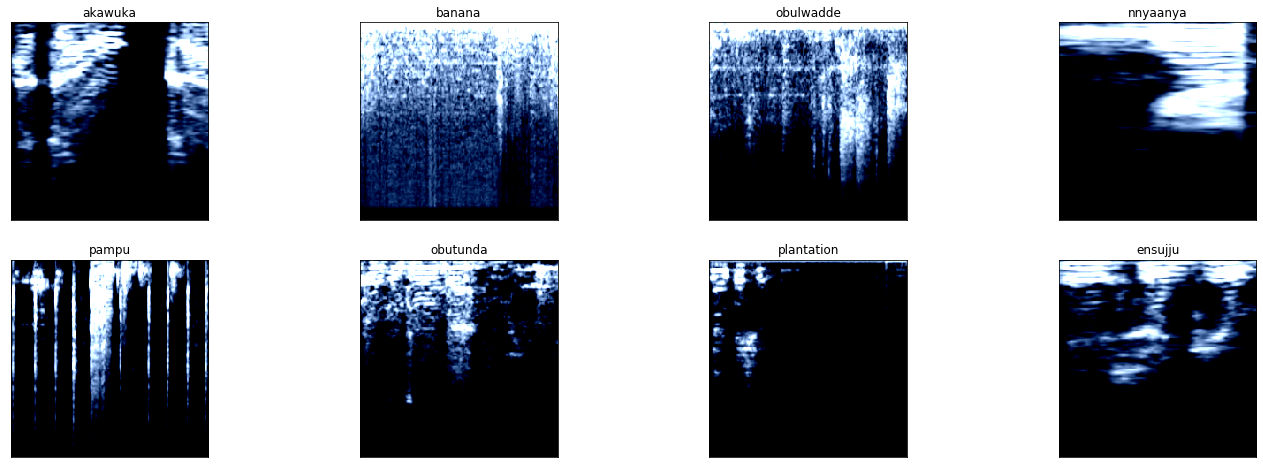

In [351]:
visualize_data("any")

In [303]:
image_transforms_train = albumentations.Compose([
    albumentations.Resize(224, 224),
#     albumentations.HorizontalFlip(),
#     albumentations.RandomBrightness(),
#     albumentations.ShiftScaleRotate(rotate_limit=15, scale_limit=0.10),
#     albumentations.JpegCompression(80),
#     albumentations.HueSaturationValue(),
    albumentations.Normalize(),
    ToTensor()
    ])
image_transforms_test = albumentations.Compose([
    albumentations.Resize(512, 512),
    albumentations.Normalize(),
    ToTensor()
    ])

In [299]:
# Use language as a feature, number of syllables
# df_train.label.unique()

In [356]:
df_train.sort_values("label")["label"].unique()

array(['Pump', 'Spinach', 'abalimi', 'afukirira', 'agriculture',
       'akammwanyi', 'akamonde', 'akasaanyi', 'akatunda', 'akatungulu',
       'akawuka', 'amakoola', 'amakungula', 'amalagala', 'amappapaali',
       'amatooke', 'banana', 'beans', 'bibala', 'bulimi', 'butterfly',
       'cabbages', 'cassava', 'caterpillar', 'caterpillars', 'coffee',
       'crop', 'ddagala', 'dig', 'disease', 'doodo', 'drought', 'ebbugga',
       'ebibala', 'ebigimusa', 'ebijanjaalo', 'ebijjanjalo', 'ebikajjo',
       'ebikolo', 'ebikongoliro', 'ebikoola', 'ebimera', 'ebinyebwa',
       'ebirime', 'ebisaanyi', 'ebisooli', 'ebisoolisooli', 'ebitooke',
       'ebiwojjolo', 'ebiwuka', 'ebyobulimi', 'eddagala', 'eggobe',
       'ejjobyo', 'ekibala', 'ekigimusa', 'ekijanjaalo', 'ekikajjo',
       'ekikolo', 'ekikoola', 'ekimera', 'ekirime', 'ekirwadde',
       'ekisaanyi', 'ekitooke', 'ekiwojjolo', 'ekyeya', 'emboga',
       'emicungwa', 'emisiri', 'emiyembe', 'emmwanyi', 'endagala',
       'endokwa', 'endwa

In [365]:
df_train.label.value_counts().tail(50)

kukungula            4
okunnoga             4
ebikolo              4
spread               4
ekikolo              4
abalimi              4
kikolo               4
watermelon           4
okusiga              4
greens               4
ensuku               4
banana               4
insects              4
npk                  4
rice                 4
mulimi               4
okukkoola            4
amakoola             4
kikajjo              4
ebbugga              4
ekimera              4
pepper               4
super grow           4
ekikoola             4
coffee               4
ekibala              3
passion fruit        3
vegetables           3
pumpkin              3
disease              3
cabbages             3
ground nuts          3
mango                3
onion                3
endokwa              3
tomatoes             3
sukumawiki           3
irish potatoes       3
sweet potatoes       3
faamu                3
beans                3
maize stalk borer    3
orange               3
matooke see

In [361]:
ipd.Audio("data/latest_keywords/pampu/5aa4893526794a73a3ed0a7ebba2a7bf_4332c4d699684614b6834fef05e8dcfb.wav")

In [367]:
ipd.Audio("data/latest_keywords/pampu/5aa4893526794a73a3ed0a7ebba2a7bf_ce0ffe8cc66d46278c7d4c2881d6fdb1.wav")

In [417]:
wav1, sr1 = librosa.load("1b5a69c4b88b41eb9577a656e11bb7dd_12df330aafd44d738ddd737e6a4eec36.wav", sr = None, mono = True)

C:\Users\Femi\.conda\envs\tensorenvironment\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [439]:
from pydub import AudioSegment
AudioSegment.converter = "C:\\ffmpeg\\bin\\ffmpeg.exe"
AudioSegment.ffmpeg = "C:\\ffmpeg\\bin\\ffmpeg.exe"
AudioSegment.ffprobe ="C:\\ffmpeg\\bin\\ffprobe.exe"

In [440]:
AudioSegment.ffmpeg

'C:\\ffmpeg\\bin\\ffmpeg.exe'

In [442]:
from pathlib import Path

In [450]:

wav2 = AudioSegment.from_wav("0a8fccdb95b749dca0404bf433872764_9d9acf15fc7a417d9e828fd6398a96dc.wav")
sound.export("W1b5a69c4b88b41eb9577a656e11bb7dd_12df330aafd44d738ddd737e6a4eec36.wav", format="wav")

FileNotFoundError: [WinError 2] The system cannot find the file specified

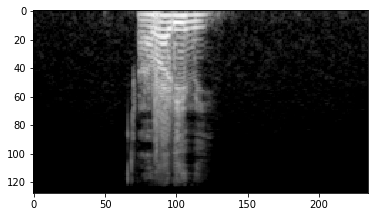

In [415]:
plt.imshow(mono_to_color(get_mel_spect(wav1, sr1)))

In [403]:
wav2, sr2 = librosa.load('audio_files/027JFNY.wav', sr = None, mono = True)

In [391]:
sr2

22050